<a href="https://colab.research.google.com/github/sagar4real/CMP7005-PRAC1/blob/main/01_data_handling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
!git clone https://github.com/sagar4real/CMP7005-PRAC1.git

fatal: destination path 'CMP7005-PRAC1' already exists and is not an empty directory.


## **Task 1 - DATA HANDLING**





### **1.1 Import Libraries**

In [50]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import math



print("Libraries imported successfully")

Libraries imported successfully


### **1.2 Load and Inspect Individual CSV Files**

In [51]:
# Folder where your CSVs are stored
DATA_FOLDER = "/content/CMP7005-PRAC1/data"

# Pattern to match your files
pattern = os.path.join(DATA_FOLDER, "*_data.csv")

# List all matching files
csv_files = sorted(glob.glob(pattern))

for(file) in csv_files:
    temp = pd.read_csv(file)
    print(file.split('/')[4] , " = " , temp.shape)

Ahmedabad_data.csv  =  (2009, 16)
Aizawl_data.csv  =  (113, 16)
Amaravati_data.csv  =  (951, 16)
Amritsar_data.csv  =  (1221, 16)
Bengaluru_data.csv  =  (2009, 16)
Bhopal_data.csv  =  (289, 16)
Brajrajnagar_data.csv  =  (938, 16)
Chandigarh_data.csv  =  (304, 16)
Chennai_data.csv  =  (2009, 16)
Coimbatore_data.csv  =  (386, 16)
Delhi_data.csv  =  (2009, 16)
Ernakulam_data.csv  =  (162, 16)
Gurugram_data.csv  =  (1679, 16)
Guwahati_data.csv  =  (502, 16)
Hyderabad_data.csv  =  (2006, 16)
Jaipur_data.csv  =  (1114, 16)
Jorapokhar_data.csv  =  (1169, 16)
Kochi_data.csv  =  (162, 16)
Kolkata_data.csv  =  (814, 16)
Lucknow_data.csv  =  (2009, 16)
Mumbai_data.csv  =  (2009, 16)
Patna_data.csv  =  (1858, 16)
Shillong_data.csv  =  (310, 16)
Talcher_data.csv  =  (925, 16)
Thiruvananthapuram_data.csv  =  (1112, 16)
Visakhapatnam_data.csv  =  (1462, 16)


### **1.3 Merge All _data.csv Files**

In [52]:
if len(csv_files) == 0:
    raise FileNotFoundError("No files found !")

# Load and append
df_list = []
for file in csv_files:
    temp = pd.read_csv(file)
    df_list.append(temp)

# Merge all into one DataFrame
merged_df = pd.concat(df_list, ignore_index=True)

### **1.5 Basic Inspection of the Merged Dataset**

In [53]:
# preview top rows
merged_df.head()

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,01/01/2015,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
1,Ahmedabad,02/01/2015,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN
2,Ahmedabad,03/01/2015,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,NaN
3,Ahmedabad,04/01/2015,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,NaN
4,Ahmedabad,05/01/2015,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,NaN


In [54]:
#preview buttom rows
merged_df.tail()

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
29526,Visakhapatnam,27/06/2020,15.02,50.94,7.68,25.06,19.54,12.47,0.47,8.55,23.30,2.24,12.07,0.73,41.0,Good
29527,Visakhapatnam,28/06/2020,24.38,74.09,3.42,26.06,16.53,11.99,0.52,12.72,30.14,0.74,2.21,0.38,70.0,Satisfactory
29528,Visakhapatnam,29/06/2020,22.91,65.73,3.45,29.53,18.33,10.71,0.48,8.42,30.96,0.01,0.01,0.00,68.0,Satisfactory
29529,Visakhapatnam,30/06/2020,16.64,49.97,4.05,29.26,18.80,10.03,0.52,9.84,28.30,0.00,0.00,0.00,54.0,Satisfactory
29530,Visakhapatnam,01/07/2020,15.00,66.00,0.40,26.85,14.05,5.20,0.59,2.10,17.05,NaN,NaN,NaN,50.0,Good


In [55]:
# check dataset structure
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29531 entries, 0 to 29530
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   City        29531 non-null  object 
 1   Date        29531 non-null  object 
 2   PM2.5       24933 non-null  float64
 3   PM10        18391 non-null  float64
 4   NO          25949 non-null  float64
 5   NO2         25946 non-null  float64
 6   NOx         25346 non-null  float64
 7   NH3         19203 non-null  float64
 8   CO          27472 non-null  float64
 9   SO2         25677 non-null  float64
 10  O3          25509 non-null  float64
 11  Benzene     23908 non-null  float64
 12  Toluene     21490 non-null  float64
 13  Xylene      11422 non-null  float64
 14  AQI         24850 non-null  float64
 15  AQI_Bucket  24850 non-null  object 
dtypes: float64(13), object(3)
memory usage: 3.6+ MB


In [56]:
# check missing values
merged_df.isnull().sum().sort_values(ascending=False).head(20)

,0
Xylene,18109
PM10,11140
NH3,10328
Toluene,8041
Benzene,5623
AQI,4681
AQI_Bucket,4681
PM2.5,4598
NOx,4185
O3,4022


In [57]:
# Summary statistics
merged_df.describe(include='all')


,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
count,29531,29531,24933.000000,18391.000000,25949.000000,25946.000000,25346.000000,19203.000000,27472.000000,25677.000000,25509.000000,23908.000000,21490.000000,11422.000000,24850.000000,24850
unique,26,2009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
top,Ahmedabad,26/06/2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Moderate
freq,2009,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8829
mean,NaN,NaN,67.450578,118.127103,17.574730,28.560659,32.309123,23.483476,2.248598,14.531977,34.491430,3.280840,8.700972,3.070128,166.463581,NaN
std,NaN,NaN,64.661449,90.605110,22.785846,24.474746,31.646011,25.684275,6.962884,18.133775,21.694928,15.811136,19.969164,6.323247,140.696585,NaN
min,NaN,NaN,0.040000,0.010000,0.020000,0.010000,0.000000,0.010000,0.000000,0.010000,0.010000,0.000000,0.000000,0.000000,13.000000,NaN
25%,NaN,NaN,28.820000,56.255000,5.630000,11.750000,12.820000,8.580000,0.510000,5.670000,18.860000,0.120000,0.600000,0.140000,81.000000,NaN
50%,NaN,NaN,48.570000,95.680000,9.890000,21.690000,23.520000,15.850000,0.890000,9.160000,30.840000,1.070000,2.970000,0.980000,118.000000,NaN
75%,NaN,NaN,80.590000,149.745000,19.950000,37.620000,40.127500,30.020000,1.450000,15.220000,45.570000,3.080000,9.150000,3.350000,208.000000,NaN


**Task 1 Report**

In this exercise I have downloaded the India Air Quality data set from Moodle and there were several csv files named ending in _data.csv. I wanted to use the same data for my analysis therefore I loaded each file into Jupyter Notebook and did an initial evaluation of the data.

First I made a list of all csv files (with the names of the csv files) available in the dataset folder. Then I loaded each one of these files separately. I then concatenated the individual files together into a single data set using **pandas.concat()** with ignore_index=True to prevent duplicate indexes.

Once the data had been merged, I conducted a preliminary assessment of the data using **.head()**, **.info()**, **.isnull().sum()** and **.describe()** to assess the structure of the data, the type of data in each column and how many missing values are present. The merged data set is now stored as **merged_df.csv** and will be the source data for the EDA in Task 2.

## **Task 2 - Exploratory Data Analysis (EDA)**

### **2.1 Fundamental data understanding**

### **2.1.1 Basic shape, columns, dtypes, sample values**

In [58]:
# 1.1 Shape, columns and dtypes
print("Rows, Columns:", merged_df.shape)
print("\nColumns:")
print(merged_df.columns.tolist())
print("\nData types:")
display(merged_df.dtypes)


Rows, Columns: (29531, 16)

Columns:
['City', 'Date', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI', 'AQI_Bucket']

Data types:


,0
City,object
Date,object
PM2.5,float64
PM10,float64
NO,float64
NO2,float64
NOx,float64
NH3,float64
CO,float64
SO2,float64


### **2.1.2 Count of missing values & percent missing**


In [59]:
# 1.2 Missing values summary
missing = merged_df.isnull().sum().sort_values(ascending=False)
missing_pct = (missing / len(merged_df) * 100).round(2)
pd.concat([missing, missing_pct.rename("pct")], axis=1).head(30)


,0,pct
Xylene,18109,61.32
PM10,11140,37.72
NH3,10328,34.97
Toluene,8041,27.23
Benzene,5623,19.04
AQI,4681,15.85
AQI_Bucket,4681,15.85
PM2.5,4598,15.57
NOx,4185,14.17
O3,4022,13.62


### **2.1.3 Unique values for categorical fields & sample city counts**

In [60]:
# 1.3 Unique categorical summaries
for col in ['City','AQI_Bucket','aqi_bucket','City_Name']:
    if col in merged_df.columns:
        print(f"\nValue counts for {col}:")
        display(merged_df[col].value_counts().head(10))

# generic approach: list object columns and show top values
obj_cols = merged_df.select_dtypes(include=['object']).columns.tolist()
print("\nObject columns detected:", obj_cols)
for c in obj_cols:
    print(f"\nTop values for '{c}':")
    display(merged_df[c].value_counts().head(8))



Value counts for City:


,count
City,
Ahmedabad,2009
Bengaluru,2009
Chennai,2009
Mumbai,2009
Lucknow,2009
Delhi,2009
Hyderabad,2006
Patna,1858
Gurugram,1679



Value counts for AQI_Bucket:


,count
AQI_Bucket,
Moderate,8829
Satisfactory,8224
Poor,2781
Very Poor,2337
Good,1341
Severe,1338



Object columns detected: ['City', 'Date', 'AQI_Bucket']

Top values for 'City':


,count
City,
Ahmedabad,2009
Bengaluru,2009
Chennai,2009
Mumbai,2009
Lucknow,2009
Delhi,2009
Hyderabad,2006
Patna,1858



Top values for 'Date':


,count
Date,
26/06/2020,26
25/06/2020,26
24/06/2020,26
23/06/2020,26
22/06/2020,26
21/06/2020,26
20/06/2020,26
19/06/2020,26



Top values for 'AQI_Bucket':


,count
AQI_Bucket,
Moderate,8829
Satisfactory,8224
Poor,2781
Very Poor,2337
Good,1341
Severe,1338


### **2.2 Data Preprocessing (cleaning, missing handling, duplicates, feature engineering)**

### **2.2.1 Remove exact duplicate rows(if any)**

In [61]:
def visualize_duplicates(df, title="Duplicate Check", preview_rows=5):
    """
    Visualizes duplicate information in a DataFrame.
    Shows:
      - Count of duplicate rows
      - Percentage of duplicates
      - Preview of duplicated rows
      - Bar chart visualizing duplicates vs uniques
    """
    dup_mask = df.duplicated(keep=False)
    dup_df = df[dup_mask]

    dup_count = dup_df.shape[0]
    total = df.shape[0]
    unique_count = total - dup_count
    percent_dup = round((dup_count / total) * 100, 2)
    percent_unique = round((unique_count / total) * 100, 2)


    # ----- BAR CHART -----
    categories = ['Duplicates', 'Unique']
    counts = [dup_count, unique_count]
    percentages = [percent_dup, percent_unique]
    colors = ['red', 'green']

    fig, ax = plt.subplots(figsize=(8, 6))

    bars = ax.bar(categories, counts, color=colors, edgecolor='black', alpha=0.8)

    # Add count and percentage labels on top of bars
    for i, (bar, count, perc) in enumerate(zip(bars, counts, percentages)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + max(counts)*0.01,
                f'{count} ({perc}%)',
                ha='center', va='bottom', fontweight='bold')

    # Add total count annotation
    # ax.text(0.5, 1.02, f'Total Rows: {total}', transform=ax.transAxes,
    #         ha='center', fontsize=12, fontweight='bold')

    ax.set_ylabel('Number of Rows', fontweight='bold')
    ax.set_title(f'{title}\nDuplicate vs Unique Rows', fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3, linestyle='--')

    # Set y-axis limit with some padding
    ax.set_ylim(0, max(counts) * 1.15)

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print(f"\n{'='*50}")
    print("DUPLICATE ANALYSIS SUMMARY:")
    print(f"{'='*50}")
    print(f"Total rows: {total}")
    print(f"Duplicate rows: {dup_count} ({percent_dup}%)")
    print(f"Unique rows: {unique_count} ({percent_unique}%)")
    print(f"{'='*50}")

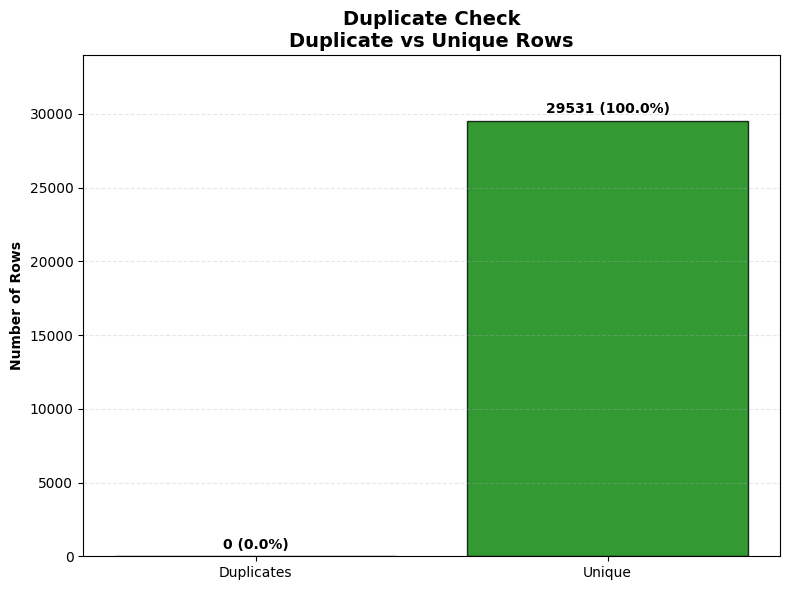


DUPLICATE ANALYSIS SUMMARY:
Total rows: 29531
Duplicate rows: 0 (0.0%)
Unique rows: 29531 (100.0%)


In [62]:
visualize_duplicates(merged_df)

Upon performing a duplicate row analysis, no duplicate entries were identified in the dataset. Therefore, no duplicate removal was required at this stage.

### **2.2.2 Convert Date to datetime & Extract Month**

In [63]:
# Convert Date column to datetime (DD/MM/YYYY format)
merged_df['Date'] = pd.to_datetime(merged_df['Date'], format="%d/%m/%Y", errors='coerce')

# Extract the Month for imputation
merged_df['Month'] = merged_df['Date'].dt.month

merged_df[['Date', 'Month']].head()

,Date,Month
0,2015-01-01,1
1,2015-01-02,1
2,2015-01-03,1
3,2015-01-04,1
4,2015-01-05,1


We convert the Date column into a proper datetime format and extract the Month so we can group the data by City and Month during missing value imputation.

### **2.2.3 Handeling missing values**

In [64]:
def visualize_missing(df, title="Missing Value Analysis"):
    """
    Visualizes missing values in a DataFrame.
    Shows:
      - Missing count
      - Missing percentage
      - Bar chart of missing percentage
    """

    # Calculate missing data
    missing_count = df.isna().sum()
    missing_percent = (df.isna().sum() / len(df)) * 100

    # Combine into a DataFrame for display
    missing_df = pd.DataFrame({
        'Missing Count': missing_count,
        'Missing %': missing_percent.round(2)
    }).sort_values(by='Missing %', ascending=False)

    print(f"\n===== {title} =====")
    display(missing_df.head(80))   # show top 20 columns with missing values

    # Plot
    plt.figure(figsize=(10,6))
    missing_df['Missing %'].plot(kind='bar', color='salmon')
    plt.title(title)
    plt.ylabel("Percentage Missing (%)")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()



===== Before Handling Missing Values =====


,Missing Count,Missing %
Xylene,18109,61.32
PM10,11140,37.72
NH3,10328,34.97
Toluene,8041,27.23
Benzene,5623,19.04
AQI_Bucket,4681,15.85
AQI,4681,15.85
PM2.5,4598,15.57
NOx,4185,14.17
O3,4022,13.62


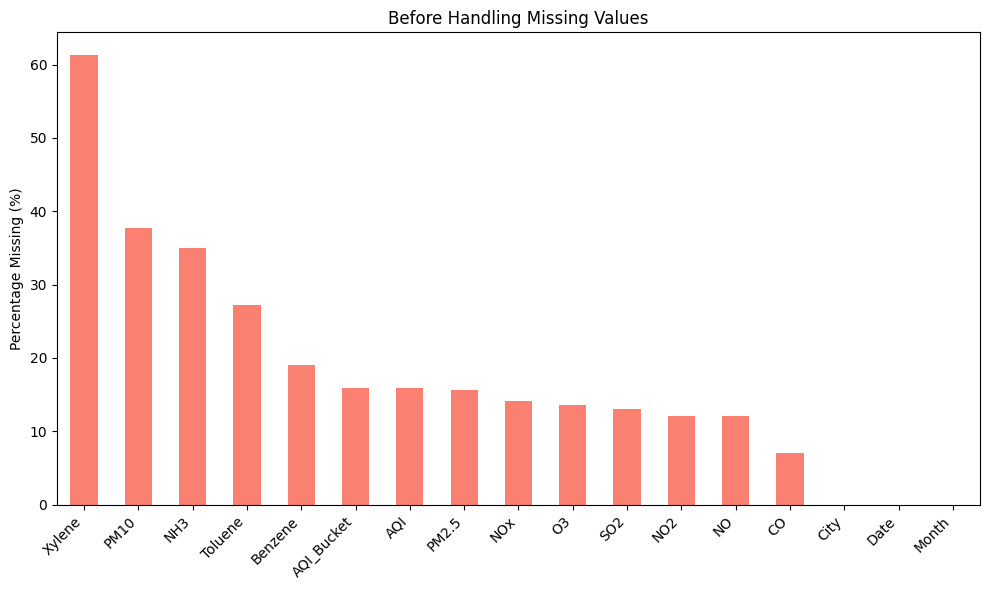

In [65]:
visualize_missing(merged_df, title="Before Handling Missing Values")


##  Missing Value Handling Method (Explanation)

To handle missing values in the India Air Quality dataset, we use a **three-level median-based imputation strategy**, which is the most suitable and scientifically accurate approach for this type of data.

###  1. City + Month Median (Main Imputation)
Air pollution levels vary significantly between different **cities** and different **months/seasons**.  
Using the *median value for each City–Month* group ensures that:

- Seasonal patterns are preserved  
- City-specific pollution behaviour is maintained  
- Imputation remains realistic and context-aware  

This prevents mixing values from cities with very different pollution levels.

---

###  2. City Median (Backup Imputation)
Some pollutants (e.g., Xylene, Benzene, Toluene, NH3) have long periods where data is not recorded in certain months.

If the City–Month median cannot be computed, we fill missing values using the **City median**.  
This keeps the regional pollution characteristics consistent without relying on unrelated cities.

---

###  3. Global Median (Final Fallback)
If values remain missing after the first two steps, we use the **overall dataset median**.  
This guarantees:
- No missing values remain  
- Imputation stays robust  
- Outliers do not distort the results (median is resistant to extreme values)

---

##  Why This Method Is the Best for This Dataset
This dataset has:
- Very high missingness in VOCs (up to 61%)  
- Large differences between cities  
- Strong seasonal pollution variation  

A simple mean/median imputation would distort pollution trends.

This **three-level hierarchical method** is ideal because it:

✔ Preserves real-world pollution patterns  
✔ Respects city-level differences  
✔ Handles large missingness sensibly  
✔ Avoids introducing bias  
✔ Produces scientifically reliable values  

This prepares the dataset for accurate EDA, modelling, and further analysis.


### **2.2.3.1 Select Numeric Pollutant Columns**

In [66]:
# List of pollutant + AQI columns we want to impute
pollutant_cols = [
    'PM2.5','PM10','NO','NO2','NOx','NH3',
    'CO','SO2','O3','Benzene','Toluene','Xylene','AQI'
]

# Keep only the ones that actually exist in your dataframe
pollutant_cols = [col for col in pollutant_cols if col in merged_df.columns]

pollutant_cols


['PM2.5',
 'PM10',
 'NO',
 'NO2',
 'NOx',
 'NH3',
 'CO',
 'SO2',
 'O3',
 'Benzene',
 'Toluene',
 'Xylene',
 'AQI']

We detect the numeric pollutant columns to ensure that only real pollutant values (PM2.5, NO2, SO2, etc.) are cleaned, preventing accidental imputation of columns like City or Date.

### **2.2.3.2 Create the Imputation Function**

In [67]:
def impute_pollutants(df, pollutant_cols):
    """
    Imputes missing values for pollutant columns using:
    1. City + Month median
    2. City median
    3. Global median
    """
    for col in pollutant_cols:

        # 1. Fill using City + Month median
        df[col] = df.groupby(['City', 'Month'])[col].transform(
            lambda x: x.fillna(x.median())
        )

        # 2. If still missing, fill with City median
        df[col] = df.groupby('City')[col].transform(
            lambda x: x.fillna(x.median())
        )

        # 3. Final fallback: global median
        df[col] = df[col].fillna(df[col].median())

    return df


Missing pollutant values were imputed using a three-level hierarchical median strategy: first at the City–Month level, then at the City level, and finally using the global median as a fallback. This method was chosen because air pollutant concentrations strongly depend on both geographical location and seasonal variation, and this approach preserves these real-world spatial and temporal patterns while ensuring no missing values remain.

In [68]:
cleaned_mearged_df = impute_pollutants(merged_df, pollutant_cols)

### **2.2.3.3 Extract unique values and counts for AQI_Bucket**

Since **AQI_Bucket** is a categorical variable derived from the numeric AQI values, we first analyse all unique category labels to check for inconsistencies and missing values. We then standardise the categories and reconstruct missing labels using official AQI threshold rules to ensure logical consistency between AQI and AQI_Bucket before further analysis.

In [69]:
cleaned_mearged_df['AQI_Bucket'] = cleaned_mearged_df['AQI_Bucket'].astype(str).str.strip()

print("Unique AQI_Bucket values:")
print(cleaned_mearged_df['AQI_Bucket'].unique())

print("\nValue counts (including missing as 'nan'):")
cleaned_mearged_df['AQI_Bucket'].value_counts(dropna=False)


Unique AQI_Bucket values:
['nan' 'Poor' 'Very Poor' 'Severe' 'Moderate' 'Satisfactory' 'Good']

Value counts (including missing as 'nan'):


,count
AQI_Bucket,
Moderate,8829
Satisfactory,8224
nan,4681
Poor,2781
Very Poor,2337
Good,1341
Severe,1338


In [70]:
def clean_aqi_bucket(df, aqi_col='AQI', bucket_col='AQI_Bucket'):
    """
    Cleans and fills AQI_Bucket using numeric AQI values.
    Steps:
    1. Standardises text values
    2. Reconstructs missing categories from AQI using official thresholds
    3. Labels remaining missing values as 'Unknown'
    """

    # --- Standardise AQI_Bucket values ---
    df[bucket_col] = df[bucket_col].astype(str).str.strip()
    df[bucket_col] = df[bucket_col].replace(['nan', 'None', 'NaN', ''], np.nan)

    # --- AQI classification rules (India standard) ---
    def classify_aqi_bucket(aqi):
        if pd.isna(aqi):
            return np.nan
        elif aqi <= 50:
            return "Good"
        elif aqi <= 100:
            return "Satisfactory"
        elif aqi <= 200:
            return "Moderate"
        elif aqi <= 300:
            return "Poor"
        elif aqi <= 400:
            return "Very Poor"
        else:
            return "Severe"

    # --- Fill missing AQI_Bucket using AQI ---
    df[bucket_col] = df[bucket_col].fillna(
        df[aqi_col].apply(classify_aqi_bucket)
    )

    # --- Final fallback ---
    df[bucket_col] = df[bucket_col].fillna("Unknown")

    return df


This function standardises the AQI_Bucket column, reconstructs missing category values using the corresponding numeric AQI based on official threshold rules, and assigns ‘Unknown’ where both values are unavailable.”

In [71]:
removed_missing_value_df = clean_aqi_bucket(cleaned_mearged_df)


===== After Handling Missing Values =====


,Missing Count,Missing %
City,0,0.0
Date,0,0.0
PM2.5,0,0.0
PM10,0,0.0
NO,0,0.0
NO2,0,0.0
NOx,0,0.0
NH3,0,0.0
CO,0,0.0
SO2,0,0.0


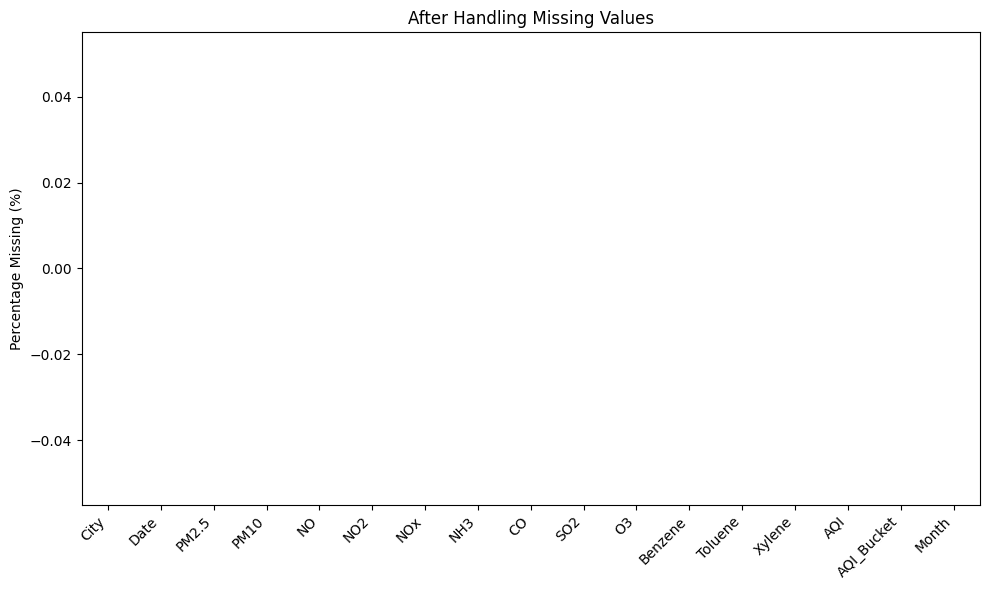

In [72]:
visualize_missing(removed_missing_value_df, title="After Handling Missing Values")

### **2.2.4 Outlier Detection & Treatment**

In this step, we analyse and treat outliers in key pollutant variables such as PM2.5, PM10, NO₂, SO₂, CO, and O₃. Outliers are identified using visual methods (boxplots) and statistical boundaries (IQR/percentile limits), then capped using winsorization to prevent extreme pollution spikes from distorting the analysis and future predictive models.

### **2.2.4.1 Select Key Pollutant Columns for Outlier Analysis**

Outlier detection will be applied only to the primary continuous pollutants (PM2.5, PM10, NO₂, CO, SO₂, and O₃) because these variables exhibit high variability, wide value ranges, and a strong influence on air quality. Categorical variables and sparse VOC measurements were excluded as outlier analysis is not statistically meaningful for them at this stage.

In [73]:
# Core pollutant columns for outlier analysis
outlier_cols = ['PM2.5', 'PM10', 'NO2', 'CO', 'SO2', 'O3']

# Keep only columns that actually exist in your dataset
outlier_cols = [col for col in outlier_cols if col in removed_missing_value_df.columns]

outlier_cols


['PM2.5', 'PM10', 'NO2', 'CO', 'SO2', 'O3']

In [74]:
def visualize_outliers_grid(df, cols, title_prefix="Outlier Visualization"):
    """
    Visualizes outliers using boxplots arranged 2 per row.
    """
    num_cols = len(cols)
    rows = math.ceil(num_cols / 2)

    plt.figure(figsize=(12, 4 * rows))

    for i, col in enumerate(cols, 1):
        plt.subplot(rows, 2, i)
        sns.boxplot(x=df[col], color='skyblue')
        plt.title(f"{title_prefix}: {col}")
        plt.xlabel(col)

    plt.tight_layout()
    plt.show()


Now we use boxplots to visualise outliers because they effectively show the distribution of pollutant values, identify extreme points beyond the whiskers, and allow quick comparison before and after outlier treatment.

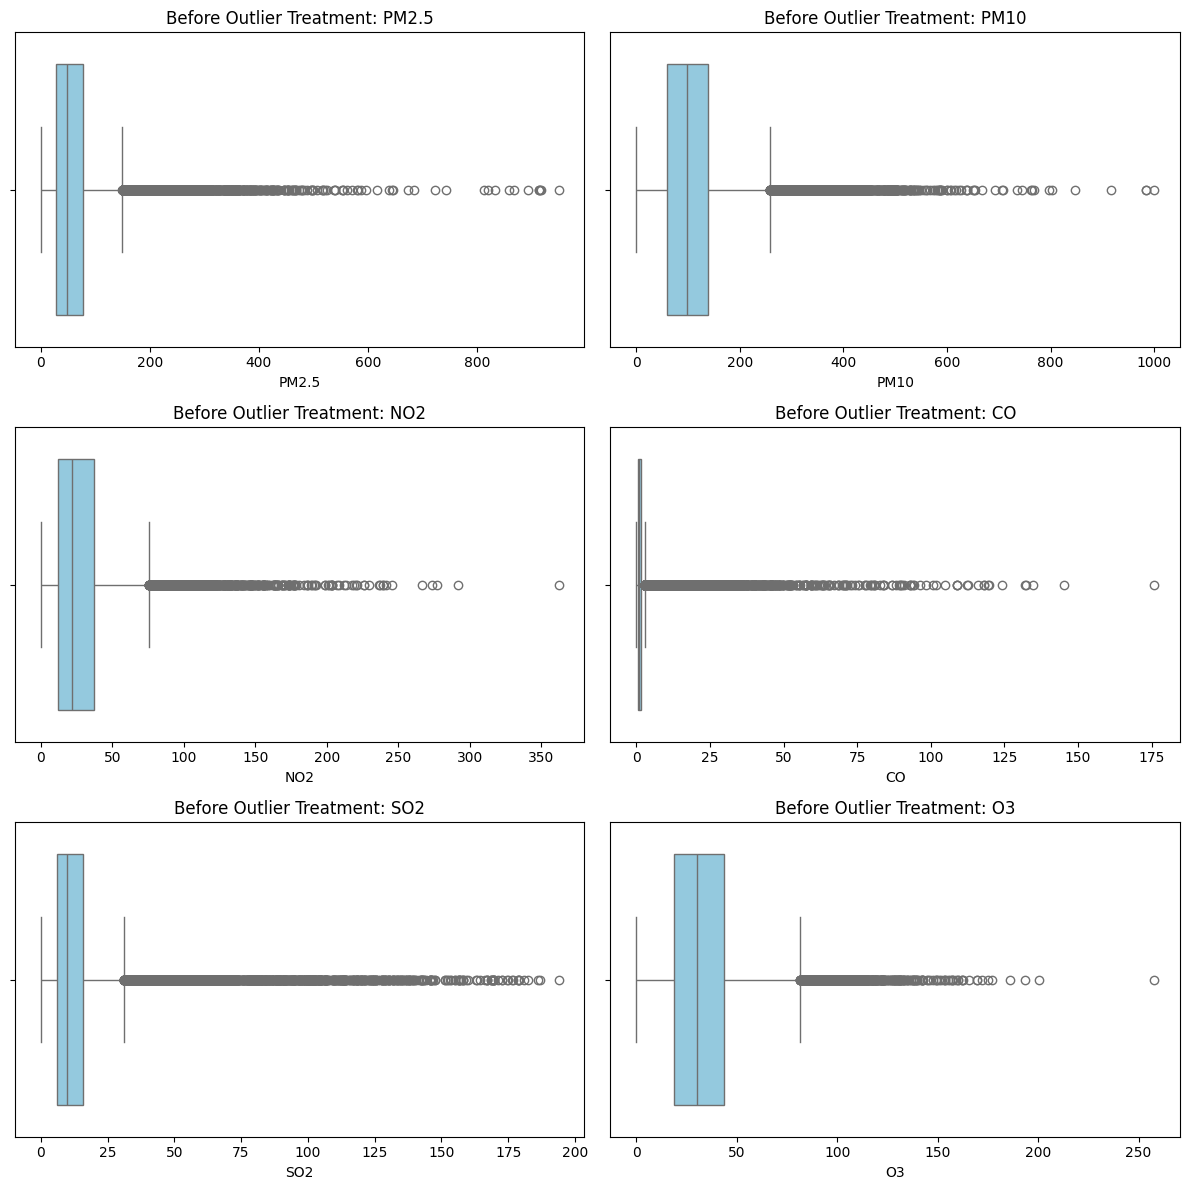

In [75]:
visualize_outliers_grid(removed_missing_value_df, outlier_cols, title_prefix="Before Outlier Treatment")

### **2.2.4.2 IQR Outlier Capping Function for Outlier Treatment**

The Interquartile Range (IQR) method identifies outliers based on the spread of the middle 50% of the data. Values falling below
𝑄
1
−
1.5
×
𝐼
𝑄
𝑅
Q1−1.5×IQR or above
𝑄
3
+
1.5
×
𝐼
𝑄
𝑅
Q3+1.5×IQR are considered extreme. Instead of removing these values, IQR-based capping limits them to the acceptable boundary range, reducing the influence of extreme pollution spikes while preserving all observations.

In [76]:
def cap_outliers_iqr(df, cols):
    """
    Caps outliers using the IQR method for the given columns.
    Outliers below the lower bound or above the upper bound are clipped.
    """
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df[col] = df[col].clip(lower_bound, upper_bound)

    return df


Outliers were treated using the Interquartile Range (IQR) method, where extreme values were capped at the lower and upper statistical bounds instead of being removed.

In [77]:
final_draft_df = cap_outliers_iqr(removed_missing_value_df, outlier_cols)


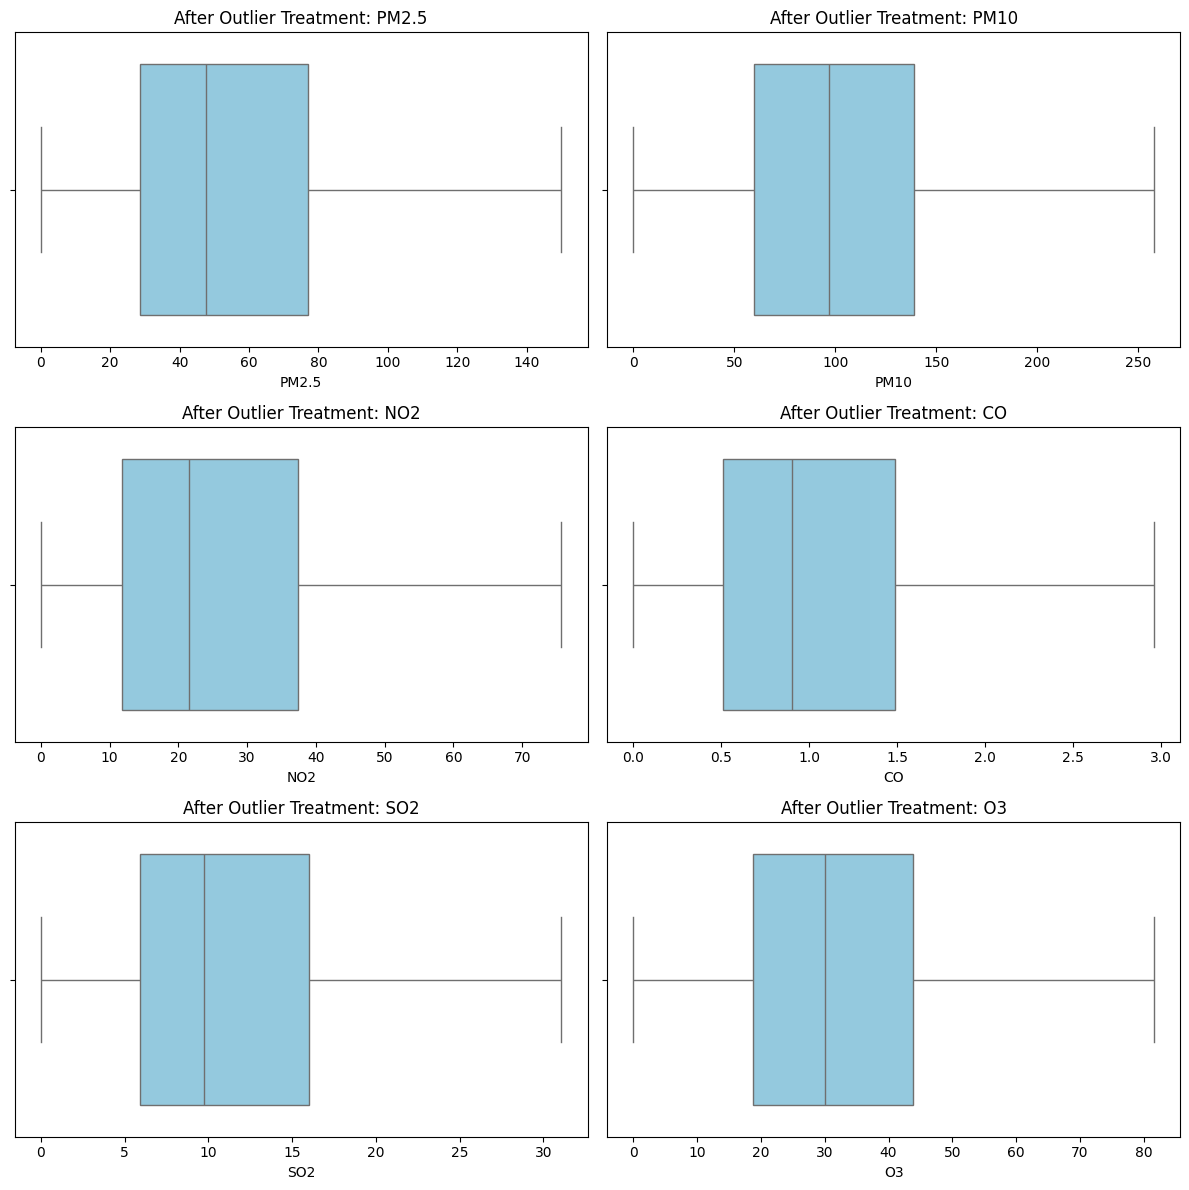

In [78]:
visualize_outliers_grid(final_draft_df, outlier_cols, title_prefix="After Outlier Treatment")

In [79]:
removed_missing_value_df.head(20)

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket,Month
0,Ahmedabad,2015-01-01,76.38,109.84,0.92,18.22,17.15,16.27,0.92,27.640,81.6025,0.00,0.02,0.00,483.0,Severe,1
1,Ahmedabad,2015-01-02,76.38,109.84,0.97,15.69,16.46,16.27,0.97,24.550,34.0600,3.68,5.50,3.77,483.0,Severe,1
2,Ahmedabad,2015-01-03,76.38,109.84,17.40,19.30,29.70,16.27,2.96,29.070,30.7000,6.80,16.40,2.25,483.0,Severe,1
3,Ahmedabad,2015-01-04,76.38,109.84,1.70,18.48,17.97,16.27,1.70,18.590,36.0800,4.43,10.14,1.00,483.0,Severe,1
4,Ahmedabad,2015-01-05,76.38,109.84,22.10,21.42,37.76,16.27,2.96,31.075,39.3100,7.01,18.89,2.78,483.0,Severe,1
5,Ahmedabad,2015-01-06,76.38,109.84,45.41,38.48,81.50,16.27,2.96,31.075,46.5100,5.42,10.83,1.93,483.0,Severe,1
6,Ahmedabad,2015-01-07,76.38,109.84,112.16,40.62,130.77,16.27,2.96,31.075,33.4700,0.00,0.00,0.00,483.0,Severe,1
7,Ahmedabad,2015-01-08,76.38,109.84,80.87,36.74,96.75,16.27,2.96,31.075,31.8900,0.00,0.00,0.00,483.0,Severe,1
8,Ahmedabad,2015-01-09,76.38,109.84,29.16,31.00,48.00,16.27,2.96,31.075,25.7500,0.00,0.00,0.00,483.0,Severe,1
9,Ahmedabad,2015-01-10,76.38,109.84,20.06,7.04,0.00,16.27,2.96,8.290,4.5500,0.00,0.00,0.00,483.0,Severe,1


### **2.3 Statistcs/computation-based analysis and Visualisation**

### **2.3.1 Statistical Summary(Automatic Numeric Detection)**

In [80]:
numeric_cols = final_draft_df.select_dtypes(include=['number']).columns

# Generate statistical summary
final_draft_df[numeric_cols].describe().T


,count,mean,std,min,25%,50%,75%,max
PM2.5,29531.0,58.762546,39.841405,0.04,28.510,47.740,77.100,149.9850
PM10,29531.0,107.680354,61.978087,0.01,59.795,96.995,138.990,257.7825
NO,29531.0,17.685793,21.673284,0.02,6.020,10.580,20.775,390.6800
NO2,29531.0,26.991742,19.304463,0.01,11.790,21.580,37.360,75.7150
NOx,29531.0,31.847368,29.798481,0.00,14.100,24.360,38.340,467.6300
NH3,29531.0,21.736289,22.174885,0.01,9.510,16.270,27.305,352.8900
CO,29531.0,1.116645,0.863183,0.00,0.510,0.900,1.490,2.9600
SO2,29531.0,12.404891,8.652249,0.01,5.950,9.740,16.000,31.0750
O3,29531.0,33.015474,18.890233,0.01,18.765,30.050,43.900,81.6025
Benzene,29531.0,2.886028,14.264577,0.00,0.170,0.970,2.690,455.0300


An  statistical summary was computed for all numeric variables to quantify central tendency, dispersion, and range using metrics such as mean, standard deviation, quartiles, and extrema. This numerical profiling provides a baseline understanding of pollutant concentration distributions prior to visual exploratory analysis.

### **2.3.2 Univariate Analysis**

In this section, we will perform univariate analysis to understand the distribution and behaviour of individual air-quality variables. Histograms are used to visualise numeric pollutant concentrations because they effectively show how values are spread, whether the data is skewed, and which ranges occur most frequently. A bar chart is used for the categorical variable AQI_Bucket to display the frequency of each air-quality category. These visualisations help identify dominant pollution levels and provide a foundation for deeper analysis in later steps.

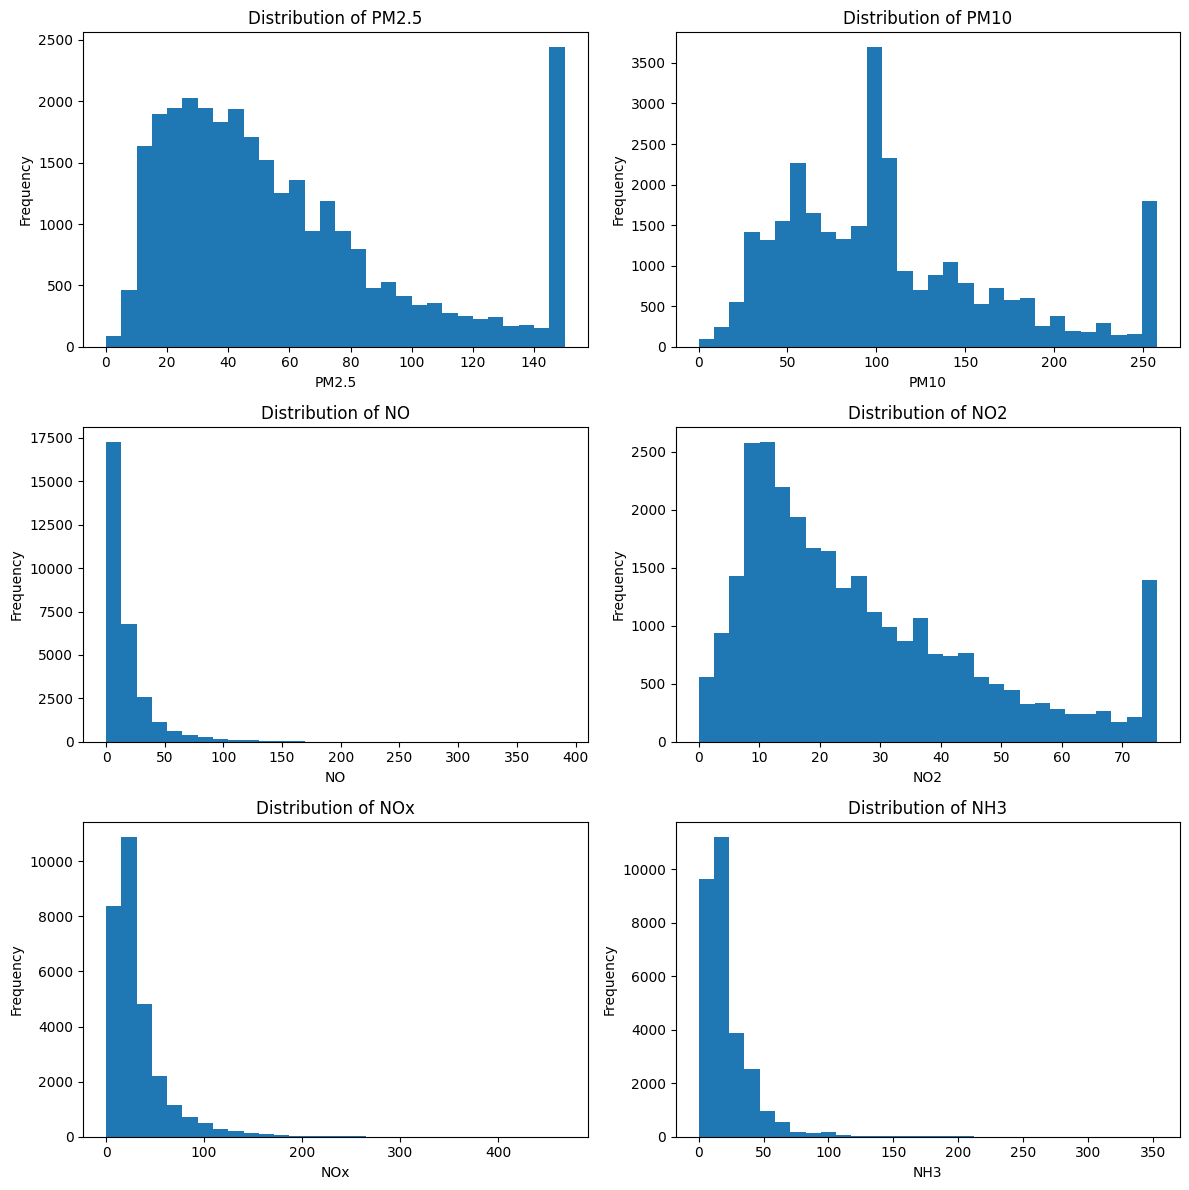

In [81]:
numeric_cols = final_draft_df.select_dtypes(include=['number']).columns.tolist()

exclude_cols = ['Month', 'Year', 'Day']
numeric_cols = [col for col in numeric_cols if col not in exclude_cols]

# Limit number of plots if you want (e.g., first 6 numeric columns)
plot_cols = numeric_cols[:6]

# --- Dynamic grid size: 2 columns ---
n_cols = 2
n_rows = math.ceil(len(plot_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()

# --- Loop through columns and plot histograms ---
for i, col in enumerate(plot_cols):
    axes[i].hist(final_draft_df[col].dropna(), bins=30)
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")

# --- Turn off any unused subplots ---
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()



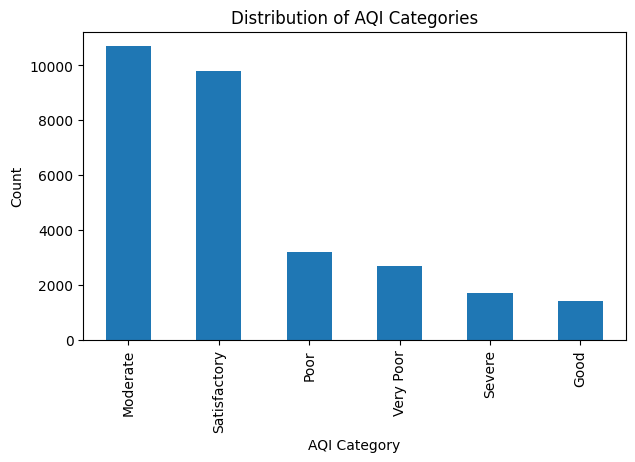

In [82]:

plt.figure(figsize=(7,4))
final_draft_df['AQI_Bucket'].value_counts().plot(kind='bar')
plt.title("Distribution of AQI Categories")
plt.xlabel("AQI Category")
plt.ylabel("Count")
plt.show()

The histograms show that most pollutants in the dataset are right-skewed, with many low to moderate values and fewer high-concentration days. PM2.5 and PM10 exhibit broad distributions with noticeable peaks, reflecting frequent moderate pollution events. Gaseous pollutants such as NO, NO₂, NOx and NH₃ show heavy right skew, indicating that high concentrations occur occasionally but not regularly. The AQI category distribution shows that ‘Moderate’ and ‘Satisfactory’ air-quality levels dominate the dataset, while ‘Poor’, ‘Very Poor’, and ‘Severe’ categories occur less frequently. Overall, the univariate analysis highlights the variability of pollutant levels and confirms that most pollutants have rare but significant high-value spikes.

### **2.3.3 Bivariate Analysis**

In this section, bivariate analysis is performed to examine the relationships between pairs of pollutants and air-quality indicators. Scatter plots are used to visualise the strength and direction of relationships between variables, while a line plot is used to observe how pollution levels change over time. These visualisations help identify correlations and real-world dependencies between air-quality variables.

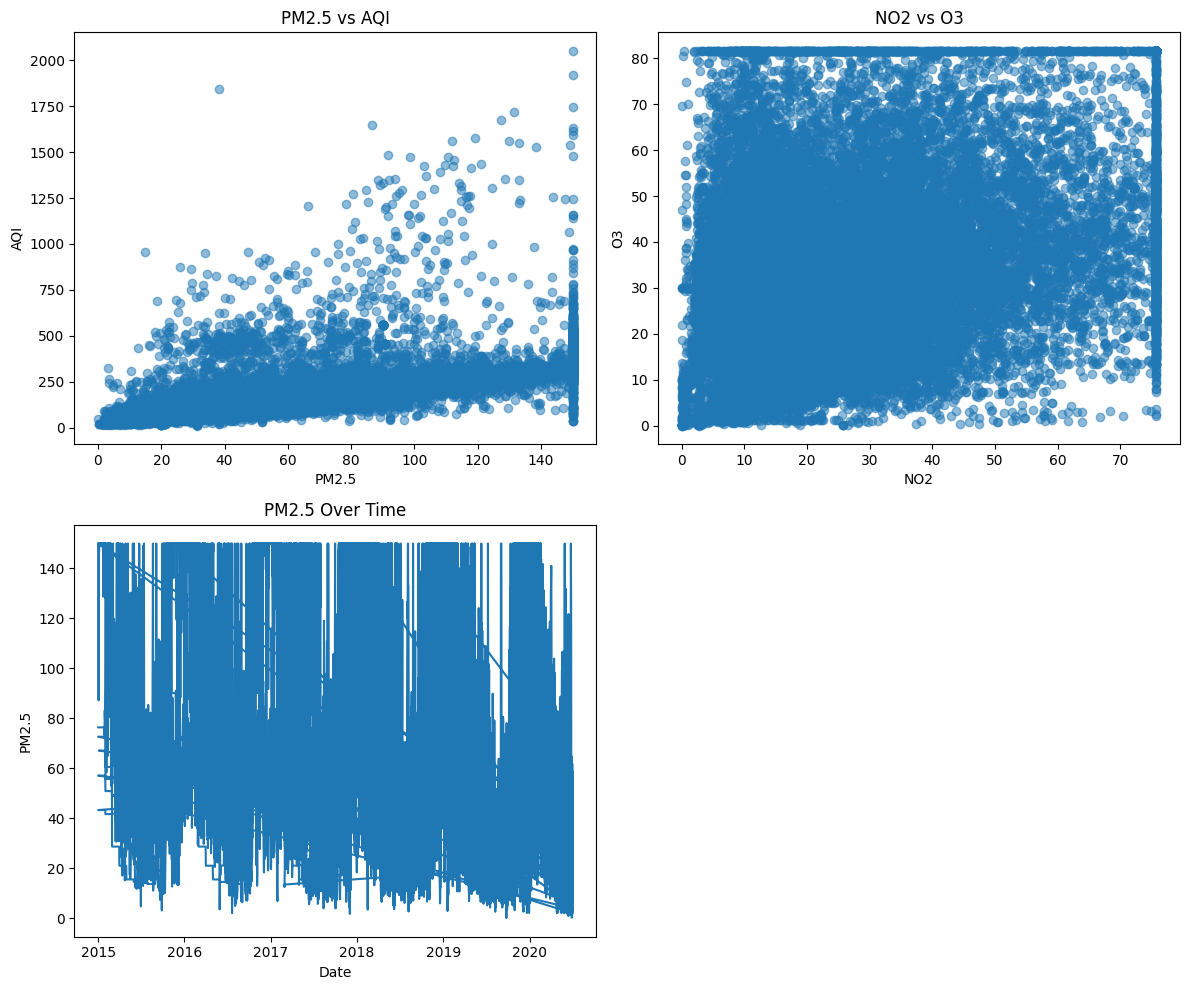

In [83]:
# --- Define bivariate plot pairs dynamically (only if columns exist) ---
bivariate_pairs = []

if 'PM2.5' in final_draft_df.columns and 'AQI' in final_draft_df.columns:
    bivariate_pairs.append(('PM2.5', 'AQI', 'scatter'))

if 'NO2' in final_draft_df.columns and 'O3' in final_draft_df.columns:
    bivariate_pairs.append(('NO2', 'O3', 'scatter'))

if 'Date' in final_draft_df.columns and 'PM2.5' in final_draft_df.columns:
    bivariate_pairs.append(('Date', 'PM2.5', 'line'))

# --- Grid layout (2 plots per row) ---
n_cols = 2
n_rows = math.ceil(len(bivariate_pairs) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5 * n_rows))
axes = axes.flatten()

# --- Plot dynamically ---
for i, (x, y, plot_type) in enumerate(bivariate_pairs):

    if plot_type == 'scatter':
        axes[i].scatter(final_draft_df[x], final_draft_df[y], alpha=0.5)
        axes[i].set_title(f"{x} vs {y}")
        axes[i].set_xlabel(x)
        axes[i].set_ylabel(y)

    elif plot_type == 'line':
        axes[i].plot(final_draft_df[x], final_draft_df[y])
        axes[i].set_title(f"{y} Over Time")
        axes[i].set_xlabel("Date")
        axes[i].set_ylabel(y)

# --- Hide unused subplots ---
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


The scatter plot of PM2.5 vs AQI shows a clear positive relationship, indicating that increases in PM2.5 levels strongly contribute to higher AQI values. The NO2 vs O3 scatter shows a weak, scattered relationship, suggesting these pollutants do not vary together consistently and may be influenced by different emission or atmospheric processes. The PM2.5 time-series plot shows strong fluctuations across years, reflecting seasonal variation with higher pollution during winter months and lower levels during monsoon seasons.

### **2.3.4 Multivariate Analysis**

In this section, multivariate analysis is performed to examine the relationships among multiple pollutants simultaneously. A correlation heatmap is used to visualise the strength and direction of relationships between variables, helping to identify strongly related pollutants and potential multicollinearity.

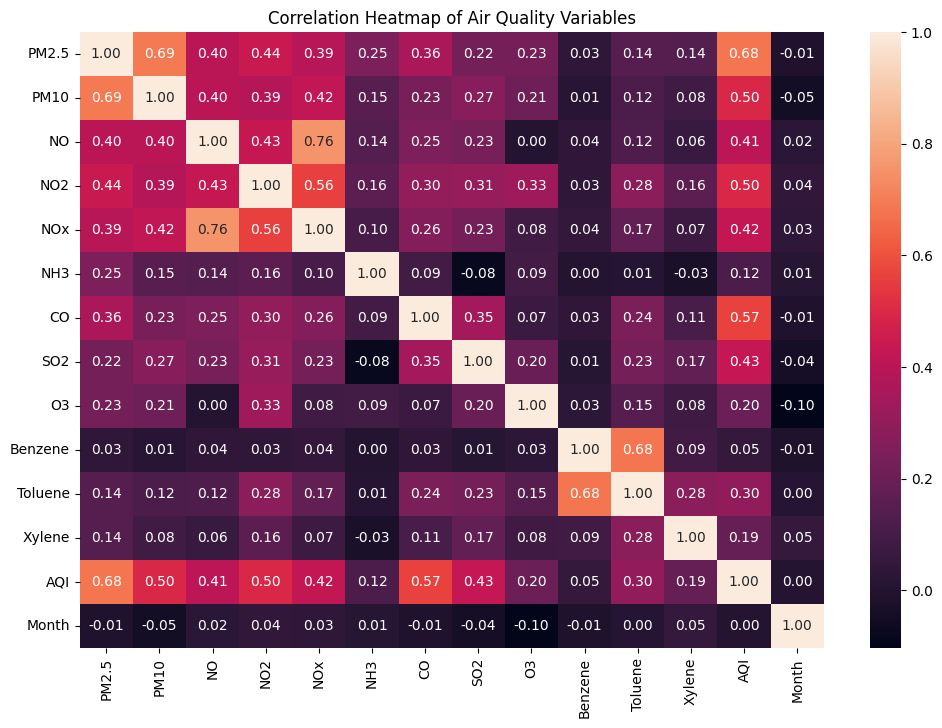

In [84]:
numeric_cols = final_draft_df.select_dtypes(include=['number'])

# Compute correlation matrix
corr_matrix = numeric_cols.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.title("Correlation Heatmap of Air Quality Variables")
plt.show()


The heatmap shows that PM2.5 and PM10 are strongly correlated (0.69), indicating that fine and coarse particulate matter increase together. AQI is also strongly related to PM2.5 (0.68) and PM10 (0.50), confirming that particulate matter is the main driver of air-quality degradation. NO and NOx show a very strong correlation (0.76), as expected due to their chemical relationship. Other pollutants such as NH3, SO2, O3, and VOCs show weak correlations, indicating they vary more independently.


**Task 2 Report**

The dataset was first explored to understand its structure, data types, and missing-value patterns. Several pollutant variables such as PM2.5, PM10, NH3, and VOCs contained substantial missing data, while City and Date were complete. Duplicate checking confirmed that no repeated records were present. A hierarchical median-based imputation strategy (City–Month → City → Global median) was applied to handle missing numeric values. The categorical variable AQI_Bucket was reconstructed from numeric AQI values using official threshold rules, and any remaining missing labels were assigned as “Unknown.”

Outlier detection was performed on key continuous pollutants (PM2.5, PM10, NO2, CO, SO2, and O3) using boxplots. Extreme values were treated using the Interquartile Range (IQR) capping method to reduce their influence while preserving all observations. Statistical summaries were generated automatically for all numeric features to understand the central tendency, spread, and range of pollutants. Univariate visualisations, including histograms and bar charts, were used to examine individual pollutant distributions and AQI category frequencies.

Bivariate and multivariate analyses were then conducted to explore relationships between variables. Scatter plots showed strong relationships between PM2.5 and AQI, and between nitrogen-based pollutants. A correlation heatmap revealed that PM2.5 and PM10 have the strongest influence on AQI, while several gaseous pollutants and VOCs exhibited weak correlations. Overall, the EDA highlighted key temporal, spatial, and pollutant-level patterns and prepared the dataset for predictive modelling in the next task.

## **Task 3 - Model Building**

In Task 3, we build predictive models to estimate air-quality levels based on pollutant data. This includes selecting an appropriate target variable, preparing machine-learning features, splitting data into training and testing sets, developing baseline and advanced models, and evaluating their performance using metrics such as MAE, RMSE, and R². The goal is to compare models and determine which provides the most accurate and reliable AQI prediction.

### **3.1 Selecting the Target Variable AQI**
Reason:



*   AQI is the most meaningful public-facing air-quality indicator.
*   It directly depends on pollutants.
*   It's numerical → easy to model.










In [85]:
final_draft_df['AQI'].isna().sum(), final_draft_df['AQI'].describe()

(np.int64(0),
 count    29531.000000
 mean       166.119535
 std        137.283534
 min         13.000000
 25%         82.000000
 50%        117.000000
 75%        207.000000
 max       2049.000000
 Name: AQI, dtype: float64)

### **3.1 Create X and Y (Features + Target)**

In [86]:
# Make a working copy
model_df = final_draft_df.copy()

# Columns we should NOT use as numeric features
drop_cols = ['Date', 'AQI_Bucket']

model_df = model_df.drop(columns=drop_cols, errors='ignore')

# Convert City into numeric (one-hot encoding)
model_df = pd.get_dummies(model_df, columns=['City'], drop_first=True)

# Target
y = model_df['AQI']

# Features
X = model_df.drop(columns=['AQI'])


AQI was selected as the target variable since it is complete and provides a meaningful numeric measure of air quality. Categorical variables such as City were converted into dummy variables, and non-predictive fields like Date and AQI_Bucket were removed to create a clean feature matrix for model development.

### **3.2 Train-Test Split**

In [87]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

# Check shapes
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((23624, 38), (5907, 38), (23624,), (5907,))

The dataset was split into training (80%) and testing (20%) sets using a fixed random seed to ensure reproducible and unbiased evaluation of model performance.”

### **3.4 Train Baseline Model (Linear Regression)**

Linear Regression is used as a baseline to provide a simple reference point for model performance.

In [88]:
from sklearn.linear_model import LinearRegression

# Initialize model
lr_model = LinearRegression()

# Train model
lr_model.fit(X_train, y_train)


LinearRegression()

### **3.5 Evalute the Baseline Model**


We evaluate using:

*   **MAE:** Average absolute error
*   **RMSE:** Penalises larger errors
*   **R²:** Proportion of variance explained



In [89]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Predictions
y_pred_lr = lr_model.predict(X_test)

# Metrics
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

mae_lr, rmse_lr, r2_lr


(35.21920989860917, np.float64(63.86968835719273), 0.7617132418158756)

### **3.6 Train Random Forest Regressor**

Random Forest can capture non-linear relationships and interactions between pollutants, which Linear Regression cannot. This makes it well-suited for complex environmental data like air quality.

In [90]:
from sklearn.ensemble import RandomForestRegressor

# Initialize model
rf_model = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

# Train model
rf_model.fit(X_train, y_train)


RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)

### **3.7 Evaluate Random Forest Model**

In [91]:
# Predictions
y_pred_rf = rf_model.predict(X_test)

# Metrics
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

mae_rf, rmse_rf, r2_rf


(20.484063843746327, np.float64(42.48568745332884), 0.8945623750808389)

A Random Forest regression model was trained to capture non-linear relationships between pollutants and AQI. The model achieved lower error values and a higher R² score compared to the baseline Linear Regression model, indicating improved predictive performance.

### **3.7 Comare Models**

In [92]:
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest'],
    'MAE': [mae_lr, mae_rf],
    'RMSE': [rmse_lr, rmse_rf],
    'R2 Score': [r2_lr, r2_rf]
})

results


,Model,MAE,RMSE,R2 Score
0,Linear Regression,35.219210,63.869688,0.761713
1,Random Forest,20.484064,42.485687,0.894562


The Random Forest model outperformed Linear Regression across all evaluation metrics, demonstrating its ability to model complex relationships in air-quality data more effectively.”

### **3.7.1 Bar Chart comparisons of Models**

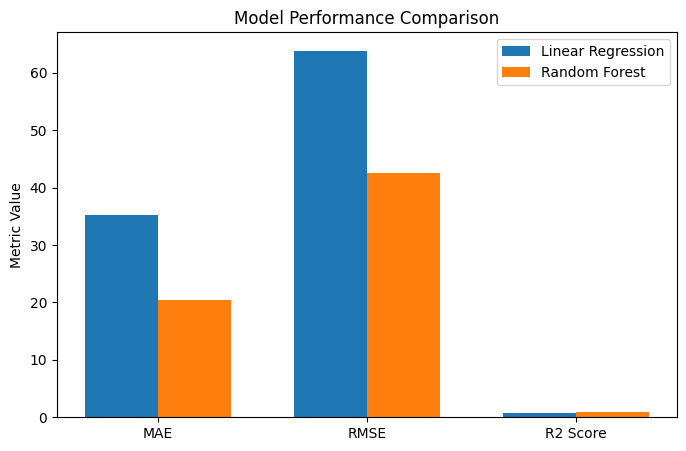

In [93]:
metrics = ['MAE', 'RMSE', 'R2 Score']
x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(8,5))

plt.bar(x - width/2, results.loc[0, metrics], width, label='Linear Regression')
plt.bar(x + width/2, results.loc[1, metrics], width, label='Random Forest')

plt.xticks(x, metrics)
plt.ylabel('Metric Value')
plt.title('Model Performance Comparison')
plt.legend()
plt.show()


The bar chart shows that the Random Forest model achieves lower MAE and RMSE and a higher R² score compared to Linear Regression, indicating superior predictive accuracy and better generalisation to unseen data.

### **3.7.2 Actual vs Predicted Scatter Plot**

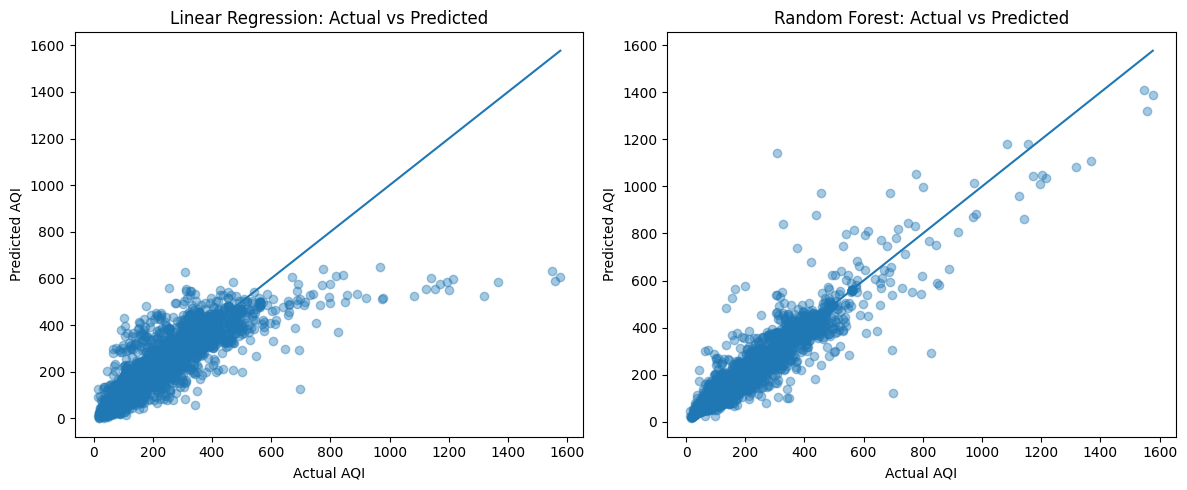

In [94]:
plt.figure(figsize=(12,5))

# Linear Regression
plt.subplot(1,2,1)
plt.scatter(y_test, y_pred_lr, alpha=0.4)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()])
plt.title('Linear Regression: Actual vs Predicted')
plt.xlabel('Actual AQI')
plt.ylabel('Predicted AQI')

# Random Forest
plt.subplot(1,2,2)
plt.scatter(y_test, y_pred_rf, alpha=0.4)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()])
plt.title('Random Forest: Actual vs Predicted')
plt.xlabel('Actual AQI')
plt.ylabel('Predicted AQI')

plt.tight_layout()
plt.show()


The Random Forest model shows predictions more closely aligned with the diagonal reference line, indicating better accuracy and reduced prediction error compared to Linear Regression.

Both numeric metrics and visual comparisons confirm that the Random Forest model outperforms the Linear Regression baseline, making it the preferred model for AQI prediction in this study.

**Task 3 Report**

In this task, predictive models were developed to estimate Air Quality Index (AQI) using the cleaned and preprocessed air-quality dataset. AQI was selected as the target variable because it provides a comprehensive numeric measure of air quality and contained no missing values. The dataset was prepared by removing non-predictive fields such as Date and AQI_Bucket, and categorical variables such as City were converted into numerical form using one-hot encoding. The data was then split into training (80%) and testing (20%) sets to enable unbiased evaluation of model performance.

A baseline Linear Regression model was first trained to establish a reference level of performance. This model assumes a linear relationship between pollutant concentrations and AQI. Model performance was evaluated using Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and the R² score. To improve predictive accuracy, a Random Forest regression model was then developed. Random Forest was chosen due to its ability to capture non-linear relationships and complex interactions among pollutants. The Random Forest model achieved lower error values and a higher R² score than the Linear Regression model, indicating superior predictive capability.

Model comparison was further supported using visualisations, including bar charts of evaluation metrics and Actual vs Predicted scatter plots. These visual analyses showed that Random Forest predictions aligned more closely with actual AQI values, while Linear Regression exhibited greater dispersion and error. Overall, the Random Forest model outperformed the baseline model and was identified as the most suitable approach for AQI prediction in this study, demonstrating the effectiveness of ensemble methods for modelling complex environmental data.

## **Task 4 - Application Development (Streamlit App)**

This task demonstrates the practical deployment of the developed AQI prediction model through an interactive application, allowing users to explore air-quality data and generate AQI predictions dynamically.

### **4.1 Save the Trained Random Forest Model**

In [96]:
!pip install joblib
import joblib

# Create models folder
os.makedirs("models", exist_ok=True)

# Save trained model
joblib.dump(rf_model, "CMP7005-PRAC1/models/aqi_random_forest_model.pkl")

# Save feature names
joblib.dump(X.columns.tolist(), "CMP7005-PRAC1/models/feature_names.pkl")

print("Model and feature names saved successfully.")



Model and feature names saved successfully.


In [97]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 94.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 101.5 MB/s eta 0:00:00


In [98]:
%%writefile app.py
import streamlit as st
import pandas as pd

# Load model and feature names
model = joblib.load("models/aqi_random_forest_model.pkl")
feature_names = joblib.load("models/feature_names.pkl")

st.title("AQI Prediction Application")
st.write("Predict Air Quality Index using pollutant values")

# Sidebar inputs
st.sidebar.header("Enter Pollutant Values")

PM25 = st.sidebar.number_input("PM2.5", 0.0, 1000.0, 50.0)
PM10 = st.sidebar.number_input("PM10", 0.0, 1000.0, 100.0)
NO2  = st.sidebar.number_input("NO2", 0.0, 500.0, 40.0)
CO   = st.sidebar.number_input("CO", 0.0, 50.0, 1.0)
SO2  = st.sidebar.number_input("SO2", 0.0, 500.0, 10.0)
O3   = st.sidebar.number_input("O3", 0.0, 500.0, 30.0)

# Create aligned input
input_df = pd.DataFrame(0, index=[0], columns=feature_names)
input_df['PM2.5'] = PM25
input_df['PM10'] = PM10
input_df['NO2'] = NO2
input_df['CO'] = CO
input_df['SO2'] = SO2
input_df['O3'] = O3

if st.button("Predict AQI"):
    prediction = model.predict(input_df)[0]
    st.success(f"Predicted AQI: {int(prediction)}")


Writing app.py


In [99]:
!wget -q -O - ipv4.icanhazip.com

35.240.239.11


In [ ]:
!streamlit run app.py & npx localtunnel --port 8501

⠙⠹⠸⠼

⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏Need to install the following packages:
localtunnel@2.0.2
Ok to proceed? (y) 
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.240.239.11:8501

Y

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋your url is: https://thirty-spiders-help.loca.lt
────────────────────────── Traceback (most recent call last) ───────────────────────────
  /usr/local/lib/python3.12/dist-packages/streamlit/runtime/scriptrunner/exec_code.py:  
  129 in exec_func_with_error_handling                                                  
                                                                                        
  /usr/local/lib/python3.12/dist-packages/streamlit/runtime/scriptrunner/script_runner  
  .py:671 in code_to_exec                                                               
                                                                                        
  /content/ap

In [ ]:
Y